## Réalisez une application de recommandation de contenu

### Présentation du projet

My Content est une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. 

Avec la co-fondatrice nous souhaitons tester une solution de recommandation d’articles et de livres à des particuliers.

Comme nous ne disposons pas de données utilisateurs, nous allons utiliser [des données disponibles en ligne](https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom/data) pour développer notre MVP (Minimum Viable Product).

Ces données représentent les interactions des utilisateurs avec les articles disponibles. Elles contiennent des informations sur les articles (par exemple le nombre de mots dans l’article), ainsi que les informations sur les sessions des utilisateurs (par exemple heures de début et de fin) et les interactions des utilisateurs avec les articles (sur quel article l’utilisateur a-t-il cliqué lors de sa session ?).

Dans une logique MVP nous avons identifié la fonctionnalité la plus critique pour lancer votre application :  "En tant qu’utilisateur de l’application, je vais recevoir une sélection de cinq articles."

Nous avons, également, identifié que la prise en compte de l’ajout de nouveaux utilisateurs et de nouveaux articles dans l’architecture cible de votre produit est déterminante.

### Présentation des données

L’ensemble de données contient un échantillon d’interactions d’utilisateurs (pages vues) sur le portail d’actualités G1 du 1er au 16 octobre 2017, y compris environ 3 millions de clics, répartis en plus d’un million de sessions de 314 000 utilisateurs qui ont lu plus de 46 000 articles de presse différents au cours de cette période.

Il est composé de trois fichiers/dossiers :

- clicks.zip : Dossier contenant des fichiers CSV (un par heure), contenant les interactions des sessions utilisateurs dans le portail d’actualités.
- articles_metadata.csv : Fichier CSV contenant des informations sur tous les articles publiés (364047).
- articles_embeddings.pickle : une matrice NumPy contenant les plongements de contenu de l’article (vecteurs à 250 dimensions), entraînée sur le texte des articles.
- clicks_sample.csv : fichier CSV contenant un échantillon des intéractions des sessions des utilisateurs.

### Importation des bibliothèques

In [14]:
from math import *
from heapq import nlargest
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import train_test_split

### Exploration du dataset

### Chargement des données

#### articles_metadata.csv

In [15]:
# Définir le chemin du répertoire
data_path = "/Users/Dhaker/Documents/Recommandation_App/projetdix/"

# Charger le fichier CSV dans un DataFrame
data = pd.read_csv(data_path + "articles_metadata.csv")

# Afficher les premières lignes du DataFrame pour vérifier le chargement
print(data.head())

   article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250
3           3            1  1408468313000             0          230
4           4            1  1407071171000             0          162


article_id : identifiant unique de l’article

category_id : la catégorie de l’article, il y a 461 catégories.

created_at_ts : secondes passées depuis de la création de l’article.

publisher_id : uiquement la valeur 0

words_count : nombre de mots dans l’article. De 0 à 6690.

In [16]:
data.dtypes

article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

In [17]:
data.isnull().sum().sort_values(ascending=False)

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

In [18]:
data["article_id"].value_counts()

article_id
0         1
242727    1
242703    1
242702    1
242701    1
         ..
121347    1
121346    1
121345    1
121344    1
364046    1
Name: count, Length: 364047, dtype: int64

In [19]:
data["category_id"].value_counts().sort_values(ascending=False)

category_id
281    12817
375    10005
399     9049
412     8648
431     7759
       ...  
283        1
282        1
206        1
217        1
0          1
Name: count, Length: 461, dtype: int64

In [20]:
data["publisher_id"].value_counts()

publisher_id
0    364047
Name: count, dtype: int64

In [21]:
data["words_count"].value_counts().sort_values(ascending=False)

words_count
176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
665        1
726        1
2881       1
669        1
841        1
Name: count, Length: 866, dtype: int64

In [22]:
data.shape

(364047, 5)

In [23]:
data.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


<function matplotlib.pyplot.show(close=None, block=None)>

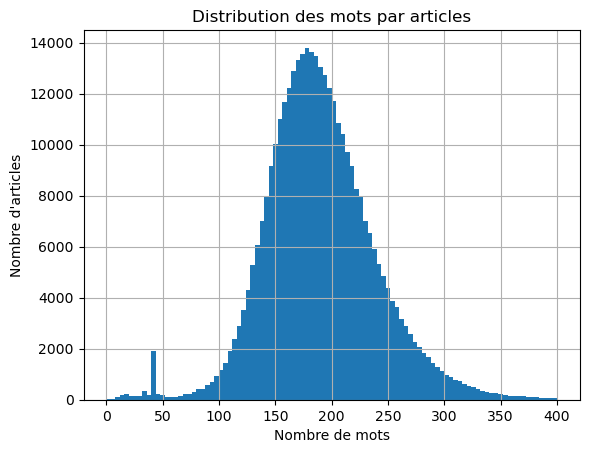

In [24]:
data['words_count'].hist(bins=100, range=(0,400))
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.title("Distribution des mots par articles")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

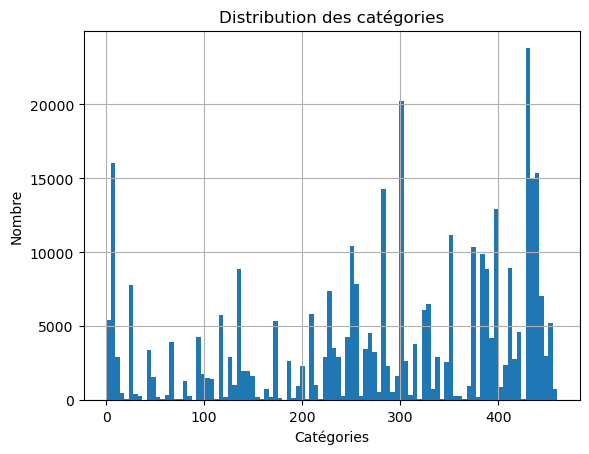

In [25]:
data['category_id'].hist(bins=100)
plt.xlabel("Catégories")
plt.ylabel("Nombre")
plt.title("Distribution des catégories")
plt.show

#### Clicks

Ce tableau recence toutes les informations relatives au sessions des utilisatuers.
4 variables nous intéressent et seront par la suite utilisées:

-User_id: identifiant unique pour chaque utilisateur.

-Session_id : l'identifiant unique de chaque session, s'il y a plusieurs clicks par session, cet identifiant peut apparaitre plusieurs fois.

-Session_size : nombre de clicks par session.

-Click_article_id : identifiant de l'article séléctionné (sur lequel l'utilisateur à cliqué).

In [26]:
# Répertoire contenant les fichiers CSV de clics
clicks_dir = "/Users/Dhaker/Documents/Recommandation_App/projetdix/clicks"

# Chemin du fichier CSV combiné
combined_csv_path = 'clicks.csv'

if not os.path.exists(combined_csv_path):
    # Liste pour stocker les chemins des fichiers CSV
    clicks_path = [
        os.path.join(clicks_dir, fname)
        for fname in os.listdir(clicks_dir)
        if fname.endswith(".csv")
    ]
    
    print("Number of clicks csv:", len(clicks_path))

    # Lire et concaténer tous les fichiers CSV
    clicks_list = [pd.read_csv(filepath) for filepath in sorted(clicks_path)]
    clicks = pd.concat(clicks_list, ignore_index=True)

    # Sauvegarder le DataFrame combiné en un seul fichier CSV
    clicks.to_csv(combined_csv_path, index=False)
else:
    # Lire le fichier CSV combiné existant
    clicks = pd.read_csv(combined_csv_path)


In [27]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [28]:
clicks.shape

(2988181, 12)

In [29]:
clicks.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


In [30]:
clicks = clicks[["user_id", "session_id", "session_size", "click_article_id", "click_timestamp"]]
clicks.head()

,user_id,session_id,session_size,click_article_id,click_timestamp
0,0,1506825423271737,2,157541,1506826828020
1,0,1506825423271737,2,68866,1506826858020
2,1,1506825426267738,2,235840,1506827017951
3,1,1506825426267738,2,96663,1506827047951
4,2,1506825435299739,2,119592,1506827090575


In [31]:
clicks.shape

(2988181, 5)

In [33]:
# Afficher les valeurs uniques dans la colonne 'click_article_id'
unique_users = clicks["user_id"].unique()
print("Articles uniques cliqués:", unique_users)
print("Nombre d'articles uniques cliqués:", len(unique_users))

Articles uniques cliqués: [     0      1      2 ... 322894 322895 322896]
Nombre d'articles uniques cliqués: 322897


<function matplotlib.pyplot.show(close=None, block=None)>

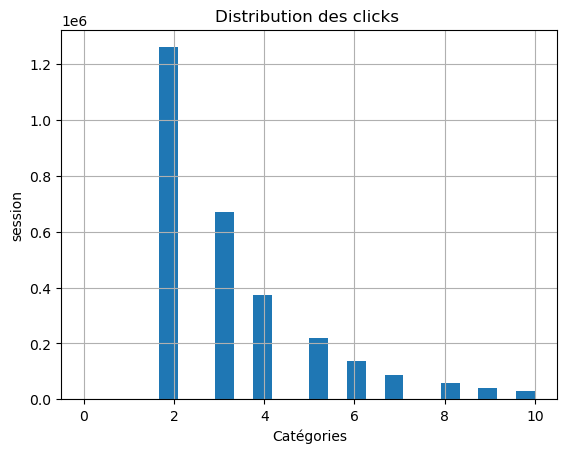

In [34]:
clicks["session_size"].hist(bins=24, range= (0, 10))
plt.xlabel("Catégories")
plt.ylabel("session")
plt.title("Distribution des clicks ")
plt.show

In [35]:
# Spécifier le chemin où enregistrer le fichier pickle
path_one = '/Users/Dhaker/Documents/Recommandation_App/azure_based_content/clicks.pkl'

# Créer le répertoire si ce n'est pas déjà fait
os.makedirs(os.path.dirname(path_one), exist_ok=True)

# Enregistrer le DataFrame en utilisant to_pickle
clicks.to_pickle(path_one)

#### articles_embeddings.pickle

In [36]:
# Lire le fichier pickle pour obtenir le NumPy array
embeddings = pd.read_pickle(data_path+ "articles_embeddings.pickle")

# Convertir le NumPy array en DataFrame pandas avec des colonnes nommées
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])

# Afficher les premières lignes du DataFrame
embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [37]:
embeddings.shape

(364047, 250)

### Prétraitement des données

#### ACP de "articles_embeddings.pickle"

Pour les besoins du projet et afin d'alléger notre algoithme pour une éventuelle mise en production, je réalise une PCA sur la base de données "articles_embeddings.pickle".
Sachant que cette base de données a été fournie pour pouvoir réaliser la "cosine similarity" sans avoir à prétraiter les données. Cette base est néanmoins très volumineuse, c'est la raison pourlaquelle je réalise une réduction de dimensionnalité. Pour cette PCA, je garde les 50 premières composantes.

In [38]:
acp = PCA(n_components=80)
acp.fit(embeddings)
embeddings_acp = acp.transform(embeddings)

In [39]:
# Convertir le NumPy array en DataFrame pandas avec des colonnes nommées
embeddings_acp = pd.DataFrame(embeddings_acp, columns=["embedding_" + str(i) for i in range(embeddings_acp.shape[1])])


embeddings_acp.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79
0,-2.176784,-1.316913,-1.029040,0.901909,-1.809547,2.064694,1.221926,0.024424,0.927228,0.669887,...,-0.288800,0.166541,0.093086,0.156313,0.051198,-0.007358,0.187129,-0.015133,-0.171407,0.249648
1,-1.735176,0.489917,3.268558,0.087841,1.473059,0.932730,-1.841611,0.881814,-0.207169,-0.816804,...,-0.042124,-0.093622,0.042270,0.170787,0.217932,-0.054633,-0.319009,-0.060909,-0.231471,-0.030410
2,-0.912696,-2.089325,1.865878,-1.202530,2.530590,0.521975,-0.224346,-1.479935,-0.191883,-1.356806,...,-0.046224,-0.235762,0.183538,0.230962,-0.030966,-0.118383,-0.098653,0.133158,0.223814,0.224828
3,1.096565,0.212976,4.183513,-0.649580,-0.130867,-1.126548,-1.063993,0.662885,0.348172,-1.463874,...,0.015628,-0.322109,0.054143,-0.100924,-0.029718,-0.103876,0.040779,0.056500,0.053858,-0.067688
4,0.193782,-0.263939,1.896580,-1.834358,1.270367,1.723294,-0.328994,-0.283787,-0.659785,-1.223764,...,0.036389,0.054548,0.036049,0.119746,-0.042471,-0.170696,-0.350483,-0.011449,0.188043,-0.140524


In [40]:
sum(acp.explained_variance_ratio_)

0.9821171728113592

In [41]:
# Spécifier le chemin où enregistrer le fichier pickle
path_two = '/Users/Dhaker/Documents/Recommandation_App/azure_based_content/embeddings_acp.pkl'

# Créer le répertoire si ce n'est pas déjà fait
os.makedirs(os.path.dirname(path_two), exist_ok=True)

# Enregistrer le DataFrame en utilisant to_pickle
embeddings_acp.to_pickle(path_two)

### Content Based Recommender

La technique de Content Based Recommender ou recommandation basée sur le contenu en français est une technique qui consiste à suggérer du contenu à un utilisateur, tel qu'il soit, sur la base des préferences de ce même utilisateur.

Pour notre présent projet, cela revient à proposer à un utilisateur, des articles qui ressemblent aux articles déja lus par ce même utilisateur. 

Pour ce faire, le système analyse les caractéristiques de ces articles et les préferences de notre utilisateur pour proposer de nouveaux articles similaires.

Dans cette partie du projet, nous avons fait le choix de réaliser notre application de recommandation de contenu en utilisant la cosine similarity ou la similarité cosinus en français.

La cosine similarity mesure l'angle entre deux vecteurs dans un espace multidimensionnel. Elle est définie comme le produit scalaire des deux vecteurs divisé par le produit de leurs normes.

Concrétement, cela revient à comparer les vecteurs de caractéristiques des articles lus par un utilisateurs avec ceux de tous les autres articles. 

Si la valeur de la cosine similarity est proche de 1, cela indique une forte similarité. En revanche, une valeur proche de 0 indique une similarité faible.

Ainsi, le systéme recommendera les articles qui présentent le plus de similarité avec les articles lus par l'utilisateur.

Se pose alors une question, c'est celle du choix de ou des articles (déja lus par un utilisateur donné) qui serviront aux calculs des cosine similarity.

Car en effet, un utilisateur peut lire un article, dans quel cas, le problème ne se pose plus puisqu'il suffit de calculer la similarité de cet article avec tous les autres articles disponibles.

Mais que se passe t'il si notre utilisateur a lu plusieurs article?

En réalité, trois principales solutions existent: 

- Soit, le dernier article lu est pris en compte.
- Soit, un article pris au hasard( parmis ceux lus par l'utilsateur).
- Soit, une moyenne des embeddings des articles lus est prise en compte.

Dans notre projet, nous avons expérimenté les 3 solutions. Evidement, il est aisé de comprendre que selon la méthode choisie, les articles recommandés ne sont pas les mêmes.

De même, et dans un soucis d'allégement de notre modèle de recommandation, nous avons réalisé une analyse en composante principale sur notre matrice des embeddings ( fournie et dont la réalisation a fait appel à la technique de "Words embedding, Tf-Idf).

Nous avons fait le choix de garder les 80 premières composantes, celles-ci captent 98% de l'inertie totale.

Nous avons constaté que les résultats sont différents selon que l'on utilise la matrice des embeddings avec ACP ou pas.

Revenons maintenant à nos 3 stratégies de choix des articles. Dans les cellule qui suit, nous avons creé un tableau qui récapitule les principales forces et faiblesses de chacunes d'entre elles.


In [8]:
import pandas as pd

# Création du tableau comparatif des stratégies de recommandation
data = {
    "Stratégie": ["Dernier Article Cliqué", "Article Cliqué au Hasard", "Moyenne des Embeddings"],
    "Qualités": [
        "- Pertinence récentes\ Simplicité\ Recommandations opportunes",
        "- Perspectives diverses\ Réduction de l'impact du bruit\ Flexibilité",
        "- Vue globale\ Stabilité\ Robustesse"
    ],
    "Faiblesses": [
        "- Contexte limité\ Sensibilité au bruit\ Perspectives historiques limitées",
        "- Incohérence\ Prévisibilité réduite\ Surcharge de calcul",
        "- Dilution des intérêts spécifiques\ Complexité de calcul\ Adaptation lente aux nouveaux intérêts"
    ]
}

# Conversion du dictionnaire en DataFrame
df_comparatif = pd.DataFrame(data)

# Ajuster les paramètres d'affichage de pandas
pd.set_option('display.max_colwidth', None)

df_comparatif

,Stratégie,Qualités,Faiblesses
0,Dernier Article Cliqué,- Pertinence récentes\ Simplicité\ Recommandations opportunes,- Contexte limité\ Sensibilité au bruit\ Perspectives historiques limitées
1,Article Cliqué au Hasard,- Perspectives diverses\ Réduction de l'impact du bruit\ Flexibilité,- Incohérence\ Prévisibilité réduite\ Surcharge de calcul
2,Moyenne des Embeddings,- Vue globale\ Stabilité\ Robustesse,- Dilution des intérêts spécifiques\ Complexité de calcul\ Adaptation lente aux nouveaux intérêts


In [10]:
# Stratégie 1 : Dernier article cliqué

def recommend_last_clicked(articles_read_embedding, articles_remaining, n=5):
    if articles_read_embedding.shape[0] == 0:
        return []
    
    # Calculer la similarité cosinus entre l'embedding du dernier article lu et les autres articles
    matrix = cosine_similarity(articles_read_embedding.iloc[-1].values.reshape(1, -1), articles_remaining.values)
    rec = []

    for i in range(n):
        coord_y = np.argmax(matrix) % matrix.shape[1]
        rec.append(int(articles_remaining.index[coord_y]))
        matrix[0][coord_y] = -np.inf  # Remplacer la valeur maximale par -inf pour éviter de la sélectionner à nouveau

    return rec

# Stratégie 2 : Article cliqué au hasard

def recommend_random_clicked(articles_read_embedding, articles_remaining, n=5):
    if articles_read_embedding.shape[0] == 0:
        return []
    
    random_index = np.random.randint(len(articles_read_embedding))
    matrix = cosine_similarity(articles_read_embedding.iloc[random_index].values.reshape(1, -1), articles_remaining.values)
    rec = []

    for i in range(n):
        coord_y = np.argmax(matrix) % matrix.shape[1]
        rec.append(int(articles_remaining.index[coord_y]))
        matrix[0][coord_y] = -np.inf  # Remplacer la valeur maximale par -inf pour éviter de la sélectionner à nouveau

    return rec

# Stratégie 3 : Moyenne des embeddings

def recommend_mean_embeddings(articles_read_embedding, articles_remaining, n=5):
    if articles_read_embedding.shape[0] == 0:
        return []
    
    mean_embedding = articles_read_embedding.mean(axis=0).values.reshape(1, -1)
    matrix = cosine_similarity(mean_embedding, articles_remaining.values)
    rec = []

    for i in range(n):
        coord_y = np.argmax(matrix) % matrix.shape[1]
        rec.append(int(articles_remaining.index[coord_y]))
        matrix[0][coord_y] = -np.inf  # Remplacer la valeur maximale par -inf pour éviter de la sélectionner à nouveau

    return rec

# Fonction principale

def contentBasedRecommendArticle(articles, clicks, user_id, strategy, n=5):
    # Articles lus par l'utilisateur, triés par timestamp
    user_clicks = clicks[clicks['user_id'] == user_id].sort_values(by='click_timestamp')
    articles_read = user_clicks['click_article_id'].tolist()

    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    # Filtrer les articles lus pour ne garder que ceux présents dans le DataFrame articles
    articles_read = [article for article in articles_read if article in articles.index]

    if len(articles_read) == 0:
        return "Aucun des articles lus par l'utilisateur ne se trouve dans le DataFrame des embeddings"

    # Embeddings des articles lus par l'utilisateur
    articles_read_embedding = articles.loc[articles_read]

    # Supprimer les articles lus du DataFrame articles
    articles_remaining = articles.drop(articles_read)

    # Appliquer la stratégie choisie
    if strategy == 'last_clicked':
        return recommend_last_clicked(articles_read_embedding, articles_remaining, n)
    elif strategy == 'random_clicked':
        return recommend_random_clicked(articles_read_embedding, articles_remaining, n)
    elif strategy == 'mean_embeddings':
        return recommend_mean_embeddings(articles_read_embedding, articles_remaining, n)
    else:
        return "Stratégie non reconnue. Choisissez parmi 'last_clicked', 'random_clicked' ou 'mean_embeddings'."

#### Inférences

#### Exemple avec la matrice d'embeddings sans ACP

In [178]:
user_id = 5  # Exemple de user_id
strategy = 'mean_embeddings'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 5 (stratégie: mean_embeddings): [285728, 285233, 280901, 345218, 286255]


In [180]:
user_id = 10  # Exemple de user_id
strategy = 'last_clicked'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 10 (stratégie: last_clicked): [205847, 207887, 207156, 206194, 207386]


In [170]:
user_id = 123  # Exemple de user_id
strategy = 'random_clicked'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 123 (stratégie: random_clicked): [348036, 290490, 347629, 290523, 290475]


#### Exemples avec la matrice d'embeddings avec ACP

In [179]:
user_id = 5  # Exemple de user_id
strategy = 'mean_embeddings'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings_acp, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 5 (stratégie: mean_embeddings): [104516, 42943, 346110, 283276, 158992]


In [181]:
user_id = 10 # Exemple de user_id
strategy = 'last_clicked'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings_acp, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 10 (stratégie: last_clicked): [207887, 207156, 205847, 207386, 206109]


In [174]:
user_id = 123  # Exemple de user_id
strategy = 'random_clicked'  # Exemple de stratégie (last_clicked, random_clicked, mean_embeddings)

# Obtenir les recommandations
recommendations = contentBasedRecommendArticle(embeddings_acp, clicks, user_id, strategy, n=5)
print(f"Recommandations pour l'utilisateur {user_id} (stratégie: {strategy}): {recommendations}")

Recommandations pour l'utilisateur 123 (stratégie: random_clicked): [159563, 157129, 160675, 158663, 156852]


### Collaborative Filtering

Le Collaborative Filtering ou filtrage collaboratif en français est une technique utilisée dans les système de recommandation. Elle vise à prédire les préfernces d'un utilisateur en se basant sur d'autres utilisateurs similaires.

Pour réaliser notre systéme de recommandation d'articles basé sur la technique du collaborative filtering, nous utilisons un modèle SVD ( Singular Value Decomposition) implémenté dans la bibliothéque Surprise qui est une bibliothèque Python dédiée à la cosntruction et à l'analyse des systèmes de recommandation.

SVD permet de prédire les scores que pourrait donner un utilisateur à des articles non lus sur la base des notes qu'ont effectivement accordé des utilisateurs similaires à ces mêmes articles.

Pour ce faire, donc, nous avons besoin d'avoir accés aux évaluations faites par l'ensemble des utilisateurs de tous les articles de notre bas de donnée et ce afin de pouvoir prédire, pour chaque utilisateur, la note qu'il aurait donné à un article s'il l'avais lu.

Or, pour notre projet, nous ne disposons pas de telles données. Il faut par conséquent contruire un score personnalisé qu'il faudra calculer en divisant le nombre de clicks sur un article donné par l'ensemble des clicks réalisés par l'utilisateur.

Ce score est compris entre 0 et 1.

In [51]:
def article_ratings(clicks):
    # Compter les clics par article et utilisateur
    user_article_clicks = clicks.groupby(['user_id', 'click_article_id']).size().reset_index(name='click_count')
    
    # Compter les clics totaux par utilisateur
    user_total_clicks = clicks.groupby('user_id')['click_article_id'].count().reset_index(name='total_clicks')
    
    # Fusionner les données de clics par article et totaux par utilisateur
    ratings = pd.merge(user_article_clicks, user_total_clicks, on='user_id')
    
    # Calculer la proportion des clics pour chaque article
    ratings['rating'] = ratings['click_count'] / ratings['total_clicks']
    
    # Nettoyer le DataFrame final
    ratings = ratings.drop(columns=['click_count', 'total_clicks'])
    ratings = ratings.rename(columns={'click_article_id': 'article_id'})
    
    return ratings

In [52]:
# Calculer les ratings
ratings = article_ratings(clicks)
print(ratings.head())

   user_id  article_id  rating
0        0       68866   0.125
1        0       87205   0.125
2        0       87224   0.125
3        0       96755   0.125
4        0      157541   0.125


In [44]:
# Spécifier le chemin où enregistrer le fichier pickle
path_three = '/Users/Dhaker/Documents/Recommandation_App/azure_collaborative/ratings.pkl'

# Créer le répertoire si ce n'est pas déjà fait
os.makedirs(os.path.dirname(path_three), exist_ok=True)

# Enregistrer le DataFrame en utilisant to_pickle
ratings.to_pickle(path_three)

In [45]:
# Créer un Reader pour spécifier le format des données
reader = Reader(rating_scale=(0, 1))

# Charger les données dans le format surprise
df = Dataset.load_from_df(ratings[['user_id', 'article_id', 'rating']], reader)

In [46]:
# Diviser les données en ensembles d'entraînement et de test
trainset, testset = train_test_split(df, test_size=0.25)

# Créer une instance de l'algorithme SVD
algo = SVD()

# Entraîner le modèle sur l'ensemble d'entraînement
algo.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = algo.test(testset)

# Évaluer la précision du modèle
accuracy.rmse(predictions)

# Enregistrer le modèle dans un fichier avec pickle
with open('/Users/Dhaker/Documents/Recommandation_App/azure_collaborative/model_COFI.pkl', 'wb') as f:
    pickle.dump(algo, f)


RMSE: 0.1729


In [47]:
def recommend_articles(user_id, algo, ratings, n=5):
    # Obtenir tous les articles disponibles
    all_articles = ratings['article_id'].unique()
    
    # Articles déjà notés par l'utilisateur
    rated_articles = ratings[ratings['user_id'] == user_id]['article_id'].values
    
    # Articles non notés par l'utilisateur
    unrated_articles = [article for article in all_articles if article not in rated_articles]
    
    # Prédire les notes pour les articles non notés
    predictions = [algo.predict(user_id, article) for article in unrated_articles]
    
    # Trier les articles par note prédite
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    
    # Retourner les n meilleurs articles recommandés
    recommended_article_ids = [pred.iid for pred in sorted_predictions[:n]]
    return recommended_article_ids

In [48]:
# Obtenir les recommandations pour un utilisateur spécifique
user_id = 4
recommended_articles = recommend_articles(user_id, algo, ratings)
print(f"Articles recommandés pour l'utilisateur {user_id}: {recommended_articles}")

Articles recommandés pour l'utilisateur 4: [250725, 114782, 268635, 298158, 338492]


In [49]:
# Obtenir les recommandations pour un utilisateur spécifique
user_id = 135
recommended_articles = recommend_articles(user_id, algo, ratings)
print(f"Articles recommandés pour l'utilisateur {user_id}: {recommended_articles}")

Articles recommandés pour l'utilisateur 135: [340931, 167041, 65802, 19470, 190954]


In [50]:
# Obtenir les recommandations pour un utilisateur spécifique
user_id = 0
recommended_articles = recommend_articles(user_id, algo, ratings)
print(f"Articles recommandés pour l'utilisateur {user_id}: {recommended_articles}")

Articles recommandés pour l'utilisateur 0: [115017, 236250, 204678, 356603, 66234]
